# Case 2. Instagram data - Marketing. Burger King vs McDonalds

Enrique Herreros & Vincent Stangenberger  
27/Sept/2016  
Fundamentals of Data Science  
MSc Data Science  
University of Amsterdam  

Interesting links:
- Instagram Scraper without Insta API, just Selenium: https://github.com/helloitsim/InstAnalytics/blob/master/InstAnalytics.py
- Facebook info in Gephi: https://blog.ouseful.info/2010/04/16/getting-started-with-gephi-network-visualisation-app-my-facebook-network-part-i/
- Neo4j
  - Merge http://graphaware.com/neo4j/2014/07/31/cypher-merge-explained.html
  - Loading CSV and defining nodes and relations: https://neo4j.com/developer/guide-importing-data-and-etl/

### Data pre-processing

In [159]:
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re  # regular expressions
import nltk  # draw on the Python natural language toolkit
from ast import literal_eval
import time
from collections import Counter
from textblob import TextBlob

Configure display options

In [160]:
matplotlib.style.use('ggplot')
%matplotlib inline 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.max_colwidth = 200
pd.set_option('display.width', 1000)

#### Data load

In [161]:
D_DIR = "../data/"
mcdonalds_icmr = "mcdonalds/icmr_mcdonalds_v2.csv"
mcdonalds_icmr_clean = "mcdonalds/df_mc_20161005.pkl"
burgerking_icmr_clean = "mcdonalds/df_bk_20161005.pkl"
mcdonalds_icmr_labels = "mcdonalds/icmr_mcdonalds_labels_v2.csv"
burgerking_icmr = "burgerking/icmr_burgerking_v2.csv"
burgerking_icmr_labels = "burgerking/icmr_burgerking_labels_v2.csv"
allFiles = [D_DIR + mcdonalds_icmr,D_DIR + burgerking_icmr]

first time, if data is not cooked yet:

In [7]:
df_mc = pd.read_csv(D_DIR + mcdonalds_icmr) # dump csv into a Pandas DataFrame
df_bk = pd.read_csv(D_DIR + burgerking_icmr) # dump csv into a Pandas DataFrame
df_mc_lab = pd.read_csv(D_DIR + mcdonalds_icmr_labels) # dump csv into a Pandas DataFrame
df_bk_lab = pd.read_csv(D_DIR + burgerking_icmr_labels) # dump csv into a Pandas DataFrame
df_all = pd.DataFrame()
df_all = pd.concat((pd.read_csv(f) for f in allFiles))

we have the cooked data in the pickle file, use it:

In [163]:
df_mc_ = pd.read_pickle(D_DIR + mcdonalds_icmr_clean) # dump csv into a Pandas DataFrame
df_bk_ = pd.read_pickle(D_DIR + burgerking_icmr_clean) # dump csv into a Pandas DataFrame

Useful functions definition

In [8]:
# open list of 1000 common english words. Source Facebook uploaded by David Langerveld
DIR = D_DIR + "/words.txt"
with open(DIR) as f:
    common_words = f.read()
    
# define list of codes to be dropped from documents
# carriage-returns, line-feeds, tabs
codelist = ['\r', '\n', '\t']    

# contractions and other word strings to drop from further analysis, adding
# to the usual English stopwords to be dropped from the document collection
more_stop_words = ['cant','didnt','doesnt','dont','goes','isnt','hes',\
    'shes','thats','theres','theyre','wont','youll','youre','youve',\
    're','tv','g','us','en','ve','vg','didn','pg','gp','our','we',
    'll','film','video','name','years','days','one','two','three', 'amp',\
    'four','five','six','seven','eight','nine','ten','eleven','twelve'] 
# start with the initial list and add to it for movie text work 
# nltk.download('corpus')
stoplist = nltk.corpus.stopwords.words('english') + more_stop_words #+ common_words.split()

# maybe using BeautifulSoup
# text parsing function for creating text documents 
# there is more we could do for data preparation 
# stemming... looking for contractions... possessives... 
# but we will work with what we have in this parsing function
# if we want to do stemming at a later time, we can use
#     porter = nltk.PorterStemmer()  
# in a construction like this
#     words_stemmed =  [porter.stem(word) for word in initial_words]  
def text_parse(string):
    # replace non-alphanumeric with space 
    temp_string = re.sub('[^a-zA-Z]', '  ', string)    
    # replace codes with space
    for i in range(len(codelist)):
        stopstring = ' ' + codelist[i] + '  '
        temp_string = re.sub(stopstring, '  ', temp_string)      
    # replace single-character words with space
    temp_string = re.sub('\s.\s', ' ', temp_string)   
    # convert uppercase to lowercase
    temp_string = temp_string.lower()    
    # replace selected character strings/stop-words with space
    for i in range(len(stoplist)):
        stopstring = ' ' + str(stoplist[i]) + ' '
        temp_string = re.sub(stopstring, ' ', temp_string)        
    # replace multiple blank characters with one blank character
    temp_string = re.sub('\s+', ' ', temp_string)    
    return(temp_string)    

def RemoveHTMLTags(data):
    p = re.compile(r'<[^<]*?>')
    return p.sub('', data)

def RemoveLinks(data):
    return re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', "", data)

def extractLinks(data):
    p = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return p.findall(data)

def removeMentions(data):
    return re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z0-9_]+)', "", data)

def removeHashtags(data):
    return re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-\.]))#([A-Za-z0-9_]+)', "", data)

def extractWebText(link):
    response = urllib2.urlopen(link)
    html = response.read()
    html = re.sub(r'\n\s*\n', '\r\n', html)
    soup = BeautifulSoup(html, 'html.parser')

    for elem in soup.find_all(['script', 'style']):
        elem.extract()

    return text_parse(RemoveHTMLTags(removeMentions(RemoveLinks(soup.get_text()))))



def removeEmoji(data):
    return re.sub(r'(\\[A-Za-z0-9_]+)',"",data)

def stemText(clean_text):
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    return " ".join([str(stemmer.stem(word)) for word in clean_text.split()])

#### find duplicates

define mappers

In [99]:
def toarray_noddq(v):
    return literal_eval(v.replace('""', '"'))

def toarray_onlyalphabet(v):
    v = re.sub("[^a-zA-Z\"\,\[\]]+", "", v)
    v = re.sub("(\"{2}\,{1,}).*?", "", v)
    v = re.sub("(\"{2}\,{1,}).*?", "", v)
    v = re.sub("\,{2,}", ",", v).replace('[,', '[').replace(',]', ']').replace(',false]', ']').replace('[false,', '[').replace(',false,', ',')
    v = v.replace(',true]', ']').replace('[true,', '[').replace(',true,', ',')
    return literal_eval(v)

def list_to_dict(df_list):
    return dict(zip(df_list['googleLabel_list'], df_list['googleLabelConfidence_list']))

apply mappers

In [14]:
df_mc['googleLabel_list'] = df_mc['googleLabel'].apply(toarray_noddq)
df_mc['googleLabelConfidence_list'] = df_mc['googleLabelConfidence'].apply(toarray_noddq)

df_bk['googleLabel_list'] = df_bk['googleLabel'].apply(toarray_noddq)
df_bk['googleLabelConfidence_list'] = df_bk['googleLabelConfidence'].apply(toarray_noddq)

merge df by id (merge googlelabels and its label confidences), then drop duplicates

In [33]:
# http://gregreda.com/2013/10/26/working-with-pandas-dataframes/

#mc
df_mc_ = pd.merge(df_mc,
             df_mc.groupby(["instaGramId"]).agg({'googleLabel_list': lambda i: list(i),
                                    'googleLabelConfidence_list': lambda i: list(i)})[['googleLabel_list', 'googleLabelConfidence_list']].reset_index(),
             on='instaGramId', how='left')
df_mc_['googleLabel_list'] = df_mc_['googleLabel_list_y'].apply(lambda x: [elm.decode("ascii", "ignore") for c in x for elm in c])
df_mc_['googleLabelConfidence_list'] = df_mc_['googleLabelConfidence_list_y'].apply(lambda x: [elm for c in x for elm in c])
df_mc_ = df_mc_.drop_duplicates(['instaGramId'], keep='first').drop(['googleLabel_list_y', 'googleLabel_list_x',
                                                           'googleLabelConfidence_list_y', 'googleLabelConfidence_list_x',
                                                          'googleLabel', 'googleLabelConfidence'], axis=1)
# bk
df_bk_ = pd.merge(df_bk_,
             df_bk_.groupby(["instaGramId"]).agg({'googleLabel_list': lambda i: list(i),
                                    'googleLabelConfidence_list': lambda i: list(i)})[['googleLabel_list', 'googleLabelConfidence_list']].reset_index(),
             on='instaGramId', how='left')
df_bk_['googleLabel_list'] = df_bk_['googleLabel_list_y'].apply(lambda x: [elm.decode("ascii", "ignore") for c in x for elm in c])
df_bk_['googleLabelConfidence_list'] = df_bk_['googleLabelConfidence_list_y'].apply(lambda x: [elm for c in x for elm in c])
df_bk_ = df_bk_.drop_duplicates(['instaGramId'], keep='first').drop(['googleLabel_list_y', 'googleLabel_list_x',
                                                           'googleLabelConfidence_list_y', 'googleLabelConfidence_list_x',
                                                          'googleLabel', 'googleLabelConfidence'], axis=1)

create dictionary out of labels & confidences

In [34]:
df_mc_['googleLabel_dict'] = df_mc_.apply(list_to_dict, axis=1)
df_bk_['googleLabel_dict'] = df_bk_.apply(list_to_dict, axis=1)

test that one of the duplicates have now all the different information merged (1161250838799772278_31334665). check last columns

In [137]:
df_mc[df_mc["instaGramId"]=="1161250838799772278_31334665"]
# how to get highest value of dict do   max(dik, key=dik.get)

,instaGramId,imageDateCreated,imageTagCount,imageFilter,imageLikeCount,imageCommentCount,imageLink,imageCaption,imageUsersInImageCollection,imageTagCollection,imageLongitude,imageLatitude,userFullName,userProfileImage,userName,userId,followedByCount,followersCount,postedMedia,userBio,userPostedLikedImage,comments,googleLabel,googleLabelConfidence,googleLogo,googleFaceCount,googleText,googleLandMark,product,brand,googleLabel_list,googleLabelConfidence_list
14,1161250838799772278_31334665,1452651909,18,Hefe,23,1,https://scontent.cdninstagram.com/hphotos-xpa1/t51.2885-15/s640x640/sh0.08/e35/12545317_1007655135963828_83915440_n.jpg,pRotoTYpe #hamburger #compact #mirror #littlemissskellyton #handmade #supporthandmade #crafty #craftymom #firstfriday FEB 5 . #foodporn #kawaii #fun #food #burger #burgerking #mcdonalds #diy #imlo...,[],"[""fun"",""burgerking"",""crafty"",""mcdonalds"",""mirror"",""compact"",""supporthandmade"",""imlovinit"",""handmade"",""diy"",""firstfriday"",""burger"",""craftymom"",""food"",""littlemissskellyton"",""hamburger"",""foodporn"",""k...",-115.025,36.0292,Muñecadraculaura,https://scontent.cdninstagram.com/hphotos-xfa1/t51.2885-19/10903432_223030637865872_1331668002_a.jpg,munecadraculaura,31334665,452,482,3215,G&S Pawn\nMother\nAmbitious\nThrifter\nCrafter \nTattooed \nDreamer\nTaken ❤️JMR 12/26/14 01/06/15 02/14/15\n💎💍 Engaged\nwww.facebook.com/littlemissskellyton,False,"[""""I love it!!!!!❤❤❤👍👍👍 @munecadraculaura""""]","[""""hamburger"""",""""cheeseburger""""]","[0.857693,0.92540771]",[],0,NaN,NaN,1,McDonalds,"[hamburger, cheeseburger]","[0.857693, 0.92540771]"
15,1161250838799772278_31334665,1452651909,18,Hefe,23,1,https://scontent.cdninstagram.com/hphotos-xpa1/t51.2885-15/s640x640/sh0.08/e35/12545317_1007655135963828_83915440_n.jpg,pRotoTYpe #hamburger #compact #mirror #littlemissskellyton #handmade #supporthandmade #crafty #craftymom #firstfriday FEB 5 . #foodporn #kawaii #fun #food #burger #burgerking #mcdonalds #diy #imlo...,[],"[""fun"",""burgerking"",""crafty"",""mcdonalds"",""mirror"",""compact"",""supporthandmade"",""imlovinit"",""handmade"",""diy"",""firstfriday"",""burger"",""craftymom"",""food"",""littlemissskellyton"",""hamburger"",""foodporn"",""k...",-115.025,36.0292,Muñecadraculaura,https://scontent.cdninstagram.com/hphotos-xfa1/t51.2885-19/10903432_223030637865872_1331668002_a.jpg,munecadraculaura,31334665,452,482,3215,G&S Pawn\nMother\nAmbitious\nThrifter\nCrafter \nTattooed \nDreamer\nTaken ❤️JMR 12/26/14 01/06/15 02/14/15\n💎💍 Engaged\nwww.facebook.com/littlemissskellyton,False,"[""""I love it!!!!!❤❤❤👍👍👍 @munecadraculaura""""]","[""""vegetable"""",""""meal"""",""""dish"""",""""food"""",""""breakfast"""",""""fruit"""",""""ingredient""""]","[0.66897607,0.74926013,0.876353,0.98684043,0.52278972,0.54963028,0.56898361]",[],0,NaN,NaN,0,McDonalds,"[vegetable, meal, dish, food, breakfast, fruit, ingredient]","[0.66897607, 0.74926013, 0.876353, 0.98684043, 0.52278972, 0.54963028, 0.56898361]"


In [138]:
df_mc_[df_mc_["instaGramId"]=="1161250838799772278_31334665"]

,instaGramId,imageDateCreated,imageTagCount,imageFilter,imageLikeCount,imageCommentCount,imageLink,imageCaption,imageUsersInImageCollection,imageTagCollection,imageLongitude,imageLatitude,userFullName,userProfileImage,userName,userId,followedByCount,followersCount,postedMedia,userBio,userPostedLikedImage,comments,googleLogo,googleFaceCount,googleText,googleLandMark,product,brand,googleLabel_list,googleLabelConfidence_list,googleLabel_dict
14,1161250838799772278_31334665,1452651909,18,Hefe,23,1,https://scontent.cdninstagram.com/hphotos-xpa1/t51.2885-15/s640x640/sh0.08/e35/12545317_1007655135963828_83915440_n.jpg,pRotoTYpe #hamburger #compact #mirror #littlemissskellyton #handmade #supporthandmade #crafty #craftymom #firstfriday FEB 5 . #foodporn #kawaii #fun #food #burger #burgerking #mcdonalds #diy #imlo...,[],"[""fun"",""burgerking"",""crafty"",""mcdonalds"",""mirror"",""compact"",""supporthandmade"",""imlovinit"",""handmade"",""diy"",""firstfriday"",""burger"",""craftymom"",""food"",""littlemissskellyton"",""hamburger"",""foodporn"",""k...",-115.025,36.0292,Muñecadraculaura,https://scontent.cdninstagram.com/hphotos-xfa1/t51.2885-19/10903432_223030637865872_1331668002_a.jpg,munecadraculaura,31334665,452,482,3215,G&S Pawn\nMother\nAmbitious\nThrifter\nCrafter \nTattooed \nDreamer\nTaken ❤️JMR 12/26/14 01/06/15 02/14/15\n💎💍 Engaged\nwww.facebook.com/littlemissskellyton,False,"[""""I love it!!!!!❤❤❤👍👍👍 @munecadraculaura""""]",[],0,NaN,NaN,1,McDonalds,"[hamburger, cheeseburger, vegetable, meal, dish, food, breakfast, fruit, ingredient]","[0.857693, 0.92540771, 0.66897607, 0.74926013, 0.876353, 0.98684043, 0.52278972, 0.54963028, 0.56898361]","{u'hamburger': 0.857693, u'food': 0.98684043, u'cheeseburger': 0.92540771, u'dish': 0.876353, u'fruit': 0.54963028, u'vegetable': 0.66897607, u'breakfast': 0.52278972, u'meal': 0.74926013, u'ingre..."


objects counter

In [164]:
all_mc_objects = []
all_mc_objects = [elm for c in df_mc_["googleLabel_list"].tolist() for elm in c]

all_bk_objects = []
all_bk_objects = [elm for c in df_bk_["googleLabel_list"].tolist() for elm in c]

In [165]:
all_mc_objects_counter = Counter(all_mc_objects).most_common(15)
all_mc_objects_counter

[(u'food', 9596),
 (u'dish', 9203),
 (u'meal', 8723),
 (u'breakfast', 5246),
 (u'dessert', 4288),
 (u'lunch', 3698),
 (u'ingredient', 3488),
 (u'flower', 3165),
 (u'person', 1987),
 (u'drink', 1957),
 (u'big mac', 1897),
 (u'brunch', 1853),
 (u'clothing', 1498),
 (u'vehicle', 1468),
 (u'child', 1319)]

In [166]:
all_bk_objects_counter = Counter(all_bk_objects).most_common(150)
all_bk_objects_counter

[(u'food', 9596),
 (u'dish', 9203),
 (u'meal', 8723),
 (u'breakfast', 5246),
 (u'dessert', 4288),
 (u'lunch', 3698),
 (u'ingredient', 3488),
 (u'flower', 3165),
 (u'person', 1987),
 (u'drink', 1957),
 (u'big mac', 1897),
 (u'brunch', 1853),
 (u'clothing', 1498),
 (u'vehicle', 1468),
 (u'child', 1319),
 (u'fast food', 1302),
 (u'people', 1250),
 (u'hamburger', 1229),
 (u'costume', 1204),
 (u'toy', 1192),
 (u'restaurant', 1064),
 (u'poultry', 1059),
 (u'coffee cup', 949),
 (u'advertising', 924),
 (u'drinkware', 920),
 (u'vegetable', 892),
 (u'model', 874),
 (u'cheeseburger', 843),
 (u'bag', 836),
 (u'art', 836),
 (u'lighting', 808),
 (u'beauty', 760),
 (u'business', 718),
 (u'home accessories', 683),
 (u'girl', 669),
 (u'hairstyle', 660),
 (u'french fries', 655),
 (u'hair', 655),
 (u'woman', 644),
 (u'smile', 637),
 (u'headgear', 633),
 (u'man', 621),
 (u'fast food restaurant', 611),
 (u'painting', 609),
 (u'album cover', 574),
 (u'human body', 570),
 (u'furniture', 563),
 (u'figurine', 

#### cleaning

In [40]:
df_mc_['imageTagCollection_list'] = df_mc_['imageTagCollection'].apply(toarray_onlyalphabet)

df_bk_['imageTagCollection_list'] = df_bk_['imageTagCollection'].apply(toarray_onlyalphabet)

Vincent: extract clean words

In [97]:
clean_mapper = lambda x: text_parse(RemoveHTMLTags(RemoveLinks(removeMentions(removeHashtags(removeEmoji(str(x))))))).split(' ')
a = time.time()
df_mc_['imageCaption_clean'] = df_mc_['imageCaption'].map(clean_mapper)
df_bk_['imageCaption_clean'] = df_bk_['imageCaption'].map(clean_mapper)
print(time.time() - a, "seconds runtime")

(743.9379999637604, 'seconds runtime')


histogram of number of faces on pictures

In [167]:
df_mc_["googleFaceCount"].value_counts(normalize=True)*100

0     70.071098
1     13.085674
2      8.112336
3      3.163882
4      2.175613
6      0.945610
5      0.931390
10     0.487025
8      0.437256
7      0.426591
9      0.131532
20     0.007110
12     0.007110
14     0.003555
24     0.003555
18     0.003555
16     0.003555
15     0.003555
Name: googleFaceCount, dtype: float64

In [45]:
df_bk_["googleFaceCount"].value_counts(normalize=True)*100

0     66.044473
1     14.304438
2     10.037964
3      4.004339
4      2.160354
5      1.093736
6      0.940071
10     0.411281
8      0.370605
7      0.357046
9      0.203381
12     0.040676
14     0.009039
18     0.004520
98     0.004520
24     0.004520
16     0.004520
20     0.004520
Name: googleFaceCount, dtype: float64

#### hashtags filtering

In [168]:
hashtag_irrelevant = ["TagsForLikes", "TagsForLikesApp", "TFLers", "tweegram", "photooftheday", "20likes", "follow4follow",
                      "like4like", "look", "instalike", "igers", "picoftheday", "instadaily", "instafollow", "followme",
                      "iphoneonly", "instagood", "bestoftheday", "instacool", "instago", "all_shots", "follow", "webstagram",
                      "instagramers", "lol", "throwbackthursday", "statigram", "instahub", "clouds", "textgram", "igaddict",
                      "my", "instalove", "niallhoran", "jj_forum", "instagrammers", "instamood", "comment", "shoutout",
                      "iphoneography", "androidography", "contests", "pics", "insta", "instafamous", "popularpic", "popularphoto",
                      "f4f", "followforfollow", "teamfollowback", "followher", "followbackteam", "followhim", "followall",
                      "followalways", "followback", "me", "pleasefollow", "follows", "follower", "following", "liker", "likes",
                      "l4l", "likes4likes", "likeforlike", "likesforlikes", "liketeam", "likeback", "likebackteam", "likeall",
                      "likealways", "liking", "comment4comment", "c4c", "commenter", "comments", "commenting", "comments4comments",
                      "commentteam", "commentback", "commentbackteam", "commentbelow", "commentall", "commentalways",
                      "pleasecomment", "shoutouts", "shout", "out", "shoutouter", "s4s", "shoutoutforshoutout", "shoutout4shoutout",
                      "so", "so4so", "ilovemyfollowers", "sobackteam", "soback", "shout_out", "followmee", "", "instagram",
                      "likelike", "followfollow", "tagsforlikes", "like", "ll", "instalike", "picoftheday", "followme", "instasize",
                      "photo", "ff", "instapic"]

In [169]:
all_mc_labels = []
all_mc_labels = [elm for c in df_mc_["imageTagCollection_list"].tolist() for elm in c if elm not in hashtag_irrelevant]

all_bk_labels = []
all_bk_labels = [elm for c in df_bk_["imageTagCollection_list"].tolist() for elm in c if elm not in hashtag_irrelevant]

In [170]:
all_mc_labels_counter = Counter(all_mc_labels).most_common(10)
all_mc_labels_counter

[('mcdonalds', 28135),
 ('food', 2378),
 ('foodporn', 1758),
 ('love', 1500),
 ('instafood', 1340),
 ('breakfast', 1190),
 ('friends', 1158),
 ('coffee', 1065),
 ('happy', 928),
 ('burger', 916)]

In [171]:
all_bk_labels_counter = Counter(all_bk_labels).most_common(10)
all_bk_labels_counter

[('mcdonalds', 28135),
 ('food', 2378),
 ('foodporn', 1758),
 ('love', 1500),
 ('instafood', 1340),
 ('breakfast', 1190),
 ('friends', 1158),
 ('coffee', 1065),
 ('happy', 928),
 ('burger', 916)]

In [172]:
food_objects = ["french fries", "mocaccino", "coffee", "fruit", "cake", "eating", "brioche", "breakfast sandwich", "baked goods",
 "snack food", "caff americano", "distilled beverage", "chinese food", "milkshake", "liqueur", "water", "kebab", "toppings",
 "alcoholic beverage", "dinner", "teriyaki", "veggie burger", "latte", "torte", "beer", "cappuccino", "yakisoba", "soft drink",
 "coffee milk", "condiment", "espresso con panna", "cheddar cheese", "profiterole", "food", "dish", "meal", "breakfast",
 "lunch", "dessert", "ingredient", "big mac", "hamburger", "fast food", "cheeseburger", "brunch", "drink", "vegetable",
 "submarine sandwich", "drinkware", "icing", "coffee cup", "chocolate cake", "fried food", "chicago style hot dog",
 "buffalo burger", "seafood", "muffuletta", "cream cheese", "osechi", "grilling", "onion ring", "sandwich", "meat pie",
 "mascarpone", "panini", "mozzarella"]

In [191]:
df_mc_.head(10)

,instaGramId,imageDateCreated,imageTagCount,imageFilter,imageLikeCount,imageCommentCount,imageLink,imageCaption,imageUsersInImageCollection,imageTagCollection,imageLongitude,imageLatitude,userFullName,userProfileImage,userName,userId,followedByCount,followersCount,postedMedia,userBio,userPostedLikedImage,comments,googleLogo,googleFaceCount,googleText,googleLandMark,product,brand,googleLabel_list,googleLabelConfidence_list,googleLabel_dict,imageTagCollection_list,imageDateCreated_str,weekend_attribute,famous_attribute,activity_attribute,imageCaption_clean,likes_followed_ratio,sentiment_attribute,filter_attribute,face_attribute,logo_attribute,food_attribute
0,1165524631240624607_638926073,1453161384,7,Normal,3,0,https://scontent.cdninstagram.com/hphotos-xpt1/t51.2885-15/s320x320/e35/12545400_131527523893372_2086774170_n.jpg,I will gladly pay you Tuesday for a hamburger today. #popeye #popeyethesailorman #wimpy #wimpysburgers #jackinthebox #mcdonalds #burgerking,[],"[""burgerking"",""popeyethesailorman"",""mcdonalds"",""wimpysburgers"",""jackinthebox"",""popeye"",""wimpy""]",-89.823100,37.913900,"""Lisa Qualls Rebman""",https://scontent.cdninstagram.com/hphotos-xaf1/t51.2885-19/s150x150/12276988_191716141166756_530478826_a.jpg,"""lisarebs""",638926073,132,268,1111,"Stay at home mom to 3 kids. Active in pregnancy & infant loss support. Dealing with a spinal disease, trying to live a happy life with minimal pain.",False,[],[],0,"""IT'S TUESDAY BITCH!!!\nWHERE'S OUR-\nFUCKING MONEY!!!""",NaN,0,McDonalds,"[cartoon, comics, artwork]","[0.92367387, 0.67196417, 0.70198238]","{u'comics': 0.67196417, u'cartoon': 0.92367387, u'artwork': 0.70198238}","[burgerking, popeyethesailorman, mcdonalds, wimpysburgers, jackinthebox, popeye, wimpy]",2016-01-18 23:56:24,weekend no,common,low,"[i, gladly, pay, tuesday, hamburger, today, ]",2.272727,0.500000,filter no,face no,logo no,food no
1,1164403947432345237_188454382,1453027789,24,Normal,27,2,https://scontent.cdninstagram.com/hphotos-xpf1/t51.2885-15/s480x480/e35/11931269_474852249364531_1430106759_n.jpg,"regram @animalrevenge\nMcDonalds, Arby's, Wendy's, Taco Bell, Burger King and all these nasty fast food chains that only serve crap to our children can go to hell!\n\nWe need more fresh markets! ...",[],"[""wendys"",""bk"",""m"",""pic"",""archdaily"",""mcdonalds"",""greenhouse"",""vegans"",""mcshit"",""govegan"",""gogreen"",""burgerking"",""tacobell"",""arbys"",""picoftheday"",""meatlessmonday"",""freshmarket"",""nongmo"",""meatismur...",-73.591152,40.709365,Angele Lbn,https://scontent.cdninstagram.com/hphotos-xpa1/t51.2885-19/s150x150/12277478_956146861113938_31544961_a.jpg,ange_0,188454382,158,136,333,Angèle ; 19yo ; 🇫🇷\nIn love with animals 🐶🐱🐹🐰🐻🐼🐨🐔🐧🐴🐝🐛🐌🐞🐍🐢 i'm also a vegetarian 🌻🌍🌏🌎,False,"[""""Yes!"""",""""Ahhh!""""]",[],0,"""icDonald\nWE NEED LESS OF THESE\nAND MORE OF THESE\nMIND""",NaN,0,McDonalds,"[amusement park, toy, fair, park]","[0.78556997, 0.62020761, 0.57394826, 0.52019644]","{u'toy': 0.62020761, u'park': 0.52019644, u'fair': 0.57394826, u'amusement park': 0.78556997}","[wendys, bk, m, pic, archdaily, mcdonalds, greenhouse, vegans, mcshit, govegan, gogreen, burgerking, tacobell, arbys, picoftheday, meatlessmonday, freshmarket, nongmo, meatismurder, vegansofig, mc...",2016-01-17 10:49:49,weekend yes,common,high,"[regram, mcdonalds, arby, wendy, taco, bell, burger, king, nasty, fast, food, chains, serve, crap, children, go, hell, need, fresh, markets, organic, gardens, greenhouses, follow, imagine, could, ...",17.088608,-0.220000,filter no,face no,logo no,food no
2,1164336631786754303_1829447035,1453019764,3,Gingham,4,1,https://scontent.cdninstagram.com/hphotos-xft1/t51.2885-15/s640x640/sh0.08/e35/12534459_212665769073084_273171575_n.jpg,When #wendys orders at #mcdonalds i guess she is #lovinit,[],"[""wendys"",""mcdonalds"",""lovinit""]",101.652507,3.165709,minaam,https://scontent.cdninstagram.com/hphotos-xtp1/t51.2885-19/10454148_899589016749832_1959853766_a.jpg,minaamkhatri,1829447

#### Create attributes for the conjoint analysis (later)  
- Famous people : number of followers: common (0-500), famous (501-15.000), very famous (>15.001)
- Activity  : formula = #likes/#followers low/average/high (0.03//0.15)
- Sentiment : positive/negative/neutral(-0.1 to 0.1)
- weekend :  yes/no
- Filter : yes/no
- Meal : burger/soda/icecream/coffee/nomeal
- Diet : healthy / unhealthy

In [198]:
def categorize_combination(df):
    if df["famous_attribute"] == "common" and df["activity_attribute"] == "high" and df["sentiment_attribute"] == "neutral":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter no" and df["face_attribute"] == "face no":
            if df["logo_attribute"] == "logo no" and df["food_attribute"] == "food no":
                return pd.Series(1)

    if df["famous_attribute"] == "common" and df["activity_attribute"] == "medium" and df["sentiment_attribute"] == "negative":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter no" and df["face_attribute"] == "face yes":
            if df["logo_attribute"] == "logo yes" and df["food_attribute"] == "food yes":
                return pd.Series(2)

    if df["famous_attribute"] == "famous" and df["activity_attribute"] == "high" and df["sentiment_attribute"] == "positive":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food yes":
                    return pd.Series(3)
                    
    if df["famous_attribute"] == "common" and df["activity_attribute"] == "low" and df["sentiment_attribute"] == "positive":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food yes":
                    return pd.Series(4)
                    
    if df["famous_attribute"] == "common" and df["activity_attribute"] == "medium" and df["sentiment_attribute"] == "negative":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food yes":
                    return pd.Series(5)
                    
    if df["famous_attribute"] == "common" and df["activity_attribute"] == "low" and df["sentiment_attribute"] == "positive":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food yes":
                    return pd.Series(6)    

    if df["famous_attribute"] == "famous" and df["activity_attribute"] == "medium" and df["sentiment_attribute"] == "neutral":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food yes":
                    return pd.Series(7)
                    
    if df["famous_attribute"] == "famous" and df["activity_attribute"] == "low" and df["sentiment_attribute"] == "negative":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food no":
                    return pd.Series(8)
                    
    if df["famous_attribute"] == "common" and df["activity_attribute"] == "low" and df["sentiment_attribute"] == "positive":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food no":
                    return pd.Series(9)
                    
    if df["famous_attribute"] == "very famous" and df["activity_attribute"] == "medium" and df["sentiment_attribute"] == "positive":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food no":
                    return pd.Series(10)
                    
    if df["famous_attribute"] == "common" and df["activity_attribute"] == "medium" and df["sentiment_attribute"] == "negative":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food no":
                    return pd.Series(11)
                    
    if df["famous_attribute"] == "famous" and df["activity_attribute"] == "medium" and df["sentiment_attribute"] == "neutral":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food yes":
                    return pd.Series(12)
                    
    if df["famous_attribute"] == "very famous" and df["activity_attribute"] == "low" and df["sentiment_attribute"] == "neutral":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food yes":
                    return pd.Series(13)
                    
    if df["famous_attribute"] == "very famous" and df["activity_attribute"] == "medium" and df["sentiment_attribute"] == "positive":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food no":
                    return pd.Series(14)

    if df["famous_attribute"] == "very famous" and df["activity_attribute"] == "medium" and df["sentiment_attribute"] == "positive":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food yes":
                    return pd.Series(15)
                    
    if df["famous_attribute"] == "famous" and df["activity_attribute"] == "low" and df["sentiment_attribute"] == "negative":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food no":
                    return pd.Series(16)
                    
    if df["famous_attribute"] == "famous" and df["activity_attribute"] == "low" and df["sentiment_attribute"] == "negative":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food yes":
                    return pd.Series(17)
                    
    if df["famous_attribute"] == "very famous" and df["activity_attribute"] == "medium" and df["sentiment_attribute"] == "positive":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food yes":
                    return pd.Series(18)   
                    
    if df["famous_attribute"] == "famous" and df["activity_attribute"] == "medium" and df["sentiment_attribute"] == "neutral":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food no":
                    return pd.Series(19)
                    
    if df["famous_attribute"] == "famous" and df["activity_attribute"] == "high" and df["sentiment_attribute"] == "positive":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food no":
                    return pd.Series(20)
                    
    if df["famous_attribute"] == "very famous" and df["activity_attribute"] == "high" and df["sentiment_attribute"] == "negative":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food yes":
                    return pd.Series(21)
                    
    if df["famous_attribute"] == "common" and df["activity_attribute"] == "high" and df["sentiment_attribute"] == "neutral":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food no":
                    return pd.Series(22)
                    
    if df["famous_attribute"] == "very famous" and df["activity_attribute"] == "low" and df["sentiment_attribute"] == "neutral":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food no":
                    return pd.Series(23)
                    
    if df["famous_attribute"] == "very famous" and df["activity_attribute"] == "low" and df["sentiment_attribute"] == "neutral":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food yes":
                    return pd.Series(24)
                    
    if df["famous_attribute"] == "common" and df["activity_attribute"] == "high" and df["sentiment_attribute"] == "neutral":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food yes":
                    return pd.Series(25)
                    
    if df["famous_attribute"] == "common" and df["activity_attribute"] == "medium" and df["sentiment_attribute"] == "negative":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food no":
                    return pd.Series(26)
                    
    if df["famous_attribute"] == "famous" and df["activity_attribute"] == "high" and df["sentiment_attribute"] == "positive":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food yes":
                    return pd.Series(27)
                    
    if df["famous_attribute"] == "famous" and df["activity_attribute"] == "high" and df["sentiment_attribute"] == "positive":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food no":
                    return pd.Series(28)
                    
    if df["famous_attribute"] == "very famous" and df["activity_attribute"] == "high" and df["sentiment_attribute"] == "negative":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food no":
                    return pd.Series(29)
                    
    if df["famous_attribute"] == "very famous" and df["activity_attribute"] == "high" and df["sentiment_attribute"] == "negative":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food yes":
                    return pd.Series(30)
                    
    if df["famous_attribute"] == "famous" and df["activity_attribute"] == "medium" and df["sentiment_attribute"] == "neutral":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food no":
                    return pd.Series(31)
                    
    if df["famous_attribute"] == "very famous" and df["activity_attribute"] == "low" and df["sentiment_attribute"] == "neutral":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter no":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food no":
                    return pd.Series(32)
                    
    if df["famous_attribute"] == "common" and df["activity_attribute"] == "low" and df["sentiment_attribute"] == "positive":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food no":
                    return pd.Series(33)
                    
    if df["famous_attribute"] == "common" and df["activity_attribute"] == "high" and df["sentiment_attribute"] == "neutral":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food yes":
                    return pd.Series(34)
                    
    if df["famous_attribute"] == "very famous" and df["activity_attribute"] == "high" and df["sentiment_attribute"] == "negative":
        if df["weekend_attribute"] == "weekend no" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face yes" and df["logo_attribute"] == "logo yes":
                if df["food_attribute"] == "food no":
                    return pd.Series(35)
                    
    if df["famous_attribute"] == "famous" and df["activity_attribute"] == "low" and df["sentiment_attribute"] == "negative":
        if df["weekend_attribute"] == "weekend yes" and df["filter_attribute"] == "filter yes":
            if df["face_attribute"] == "face no" and df["logo_attribute"] == "logo no":
                if df["food_attribute"] == "food yes":
                    return pd.Series(36) 
    return pd.Series(0) 

In [206]:
df_mc_.head(1)

,instaGramId,imageDateCreated,imageTagCount,imageFilter,imageLikeCount,imageCommentCount,imageLink,imageCaption,imageUsersInImageCollection,imageTagCollection,imageLongitude,imageLatitude,userFullName,userProfileImage,userName,userId,followedByCount,followersCount,postedMedia,userBio,userPostedLikedImage,comments,googleLogo,googleFaceCount,googleText,googleLandMark,product,brand,googleLabel_list,googleLabelConfidence_list,googleLabel_dict,imageTagCollection_list,imageDateCreated_str,weekend_attribute,famous_attribute,activity_attribute,imageCaption_clean,likes_followed_ratio,sentiment_attribute,filter_attribute,face_attribute,logo_attribute,food_attribute,sentiment_attribute_num,conjoint_category
0,1165524631240624607_638926073,1453161384,7,Normal,3,0,https://scontent.cdninstagram.com/hphotos-xpt1/t51.2885-15/s320x320/e35/12545400_131527523893372_2086774170_n.jpg,I will gladly pay you Tuesday for a hamburger today. #popeye #popeyethesailorman #wimpy #wimpysburgers #jackinthebox #mcdonalds #burgerking,[],"[""burgerking"",""popeyethesailorman"",""mcdonalds"",""wimpysburgers"",""jackinthebox"",""popeye"",""wimpy""]",-89.8231,37.9139,"""Lisa Qualls Rebman""",https://scontent.cdninstagram.com/hphotos-xaf1/t51.2885-19/s150x150/12276988_191716141166756_530478826_a.jpg,"""lisarebs""",638926073,132,268,1111,"Stay at home mom to 3 kids. Active in pregnancy & infant loss support. Dealing with a spinal disease, trying to live a happy life with minimal pain.",False,[],[],0,"""IT'S TUESDAY BITCH!!!\nWHERE'S OUR-\nFUCKING MONEY!!!""",NaN,0,McDonalds,"[cartoon, comics, artwork]","[0.92367387, 0.67196417, 0.70198238]","{u'comics': 0.67196417, u'cartoon': 0.92367387, u'artwork': 0.70198238}","[burgerking, popeyethesailorman, mcdonalds, wimpysburgers, jackinthebox, popeye, wimpy]",2016-01-18 23:56:24,weekend no,common,low,"[i, gladly, pay, tuesday, hamburger, today, ]",2.272727,positive,filter no,face no,logo no,food no,0.5,0


In [217]:
df_mc_['famous_attribute'] = df_mc_['followedByCount'].apply(lambda x: 'common' if x <= 500 else 'famous' if x <= 15000 else 'very famous')

df_bk_['famous_attribute'] = df_bk_['followedByCount'].apply(lambda x: 'common' if x <= 500 else 'famous' if x <= 15000 else 'very famous')

In [218]:
df_mc_['activity_attribute'] = (100*df_mc_['imageLikeCount'])/df_mc_['followedByCount']
df_mc_['activity_attribute'] = df_mc_['activity_attribute'].apply(lambda x: 'low' if x <= 3 else 'average' if x <= 15 else 'high')

df_bk_['activity_attribute'] = (100*df_bk_['imageLikeCount'])/df_bk_['followedByCount']
df_bk_['activity_attribute'] = df_bk_['activity_attribute'].apply(lambda x: 'low' if x <= 3 else 'average' if x <= 15 else 'high')

In [219]:
# what's the sentiment of the image's caption?
# textblob from case 1
df_mc_["sentiment_attribute_num"] = df_mc_['imageCaption_clean'].map(lambda x: float(TextBlob(" ".join(x)).sentiment[0]))
df_mc_["sentiment_attribute"] = df_mc_['sentiment_attribute_num'].map(lambda x: "negative" if float(x) < -0.05 else "neutral" if float(x) < 0.05 else "positive")

df_bk_["sentiment_attribute_num"] = df_bk_['imageCaption_clean'].map(lambda x: float(TextBlob(" ".join(x)).sentiment[0]))
df_bk_["sentiment_attribute"] = df_bk_['sentiment_attribute_num'].map(lambda x: "negative" if float(x) < -0.05 else "neutral" if float(x) < 0.05 else "positive")

In [220]:
# datetime.datetime.today().weekday() # where 0 is monday
# was the picture uploaded during the weekend?
df_mc_['imageDateCreated_str'] = pd.to_datetime(df_mc_['imageDateCreated'],unit='s')
df_mc_['weekend_attribute'] = df_mc_['imageDateCreated_str'].dt.strftime("%A")
df_mc_['weekend_attribute'] = df_mc_['weekend_attribute'].apply(lambda x: 'weekend yes' if x.lower() == "saturday" or x.lower() == "sunday" else 'weekend no')

df_bk_['imageDateCreated_str'] = pd.to_datetime(df_bk_['imageDateCreated'],unit='s')
df_bk_['weekend_attribute'] = df_bk_['imageDateCreated_str'].dt.strftime("%A")
df_bk_['weekend_attribute'] = df_bk_['weekend_attribute'].apply(lambda x: 'weekend yes' if x.lower() == "saturday" or x.lower() == "sunday" else 'weekend no')


In [221]:
# normal filter is no-filter
df_mc_['filter_attribute'] = df_mc_['imageFilter'].map(lambda x: 'filter no' if x.lower() == "normal" else 'filter yes')

df_bk_['filter_attribute'] = df_bk_['imageFilter'].map(lambda x: 'filter no' if x.lower() == "normal" else 'filter yes')

In [222]:
# are there faces in the picture?
df_mc_['face_attribute'] = df_mc_['googleFaceCount'].map(lambda x: 'face yes' if x > 0 else 'face no')

df_bk_['face_attribute'] = df_bk_['googleFaceCount'].map(lambda x: 'face yes' if x > 0 else 'face no')

In [229]:
# are there mc/bk logos in the picture?
# waiting for masoud's extra data
df_mc_['logo_attribute'] = df_mc_['googleFaceCount'].map(lambda x: 'logo yes' if x > 0 else 'logo no')

df_bk_['logo_attribute'] = df_bk_['googleFaceCount'].map(lambda x: 'logo yes' if x > 0 else 'logo no')

In [224]:
# is there food in the picture?
df_mc_['food_attribute'] = df_mc_["imageTagCollection_list"].map(lambda x: "food yes" if len(set(x).intersection(food_objects)) > 0 else "food no")

df_bk_['food_attribute'] = df_bk_["imageTagCollection_list"].map(lambda x: "food yes" if len(set(x).intersection(food_objects)) > 0 else "food no")

In [225]:
df_mc_['food_attribute'].value_counts()

food no     22341
food yes     5789
Name: food_attribute, dtype: int64

assign categories

In [226]:
#df_mc_["famous_attribute"]
#new_df = df_mc_.apply(categorize_combination, axis=1)
# test this first
df_mc_['conjoint_category'] = df_mc_.apply(categorize_combination, axis=1)
df_mc_['conjoint_category'].value_counts()

0     27125
1       496
34      256
22      153
9        53
25       22
16       13
28        5
6         5
27        2
Name: conjoint_category, dtype: int64

In [230]:
df_bk_['conjoint_category'] = df_bk_.apply(categorize_combination, axis=1)
df_bk_['conjoint_category'].value_counts()

0     27511
1       496
33       53
25       22
23       16
16       13
13        9
36        5
4         5
Name: conjoint_category, dtype: int64

In [231]:
# save all the p../data/ocessed data
df_mc_.to_pickle("../data/mcdonalds/df_mc_20161005.pkl")
df_bk_.to_pickle("../data/burgerking/df_bk_20161005.pkl")

In [133]:
# other ideas for attributes: https://bigmacvswhooper.files.wordpress.com/2013/11/555052_10152014374962427_2070642017_n.jpg
# engagement (toys, etc)? 
# histogram of colors, predominant colors + sentiment of colors wheel?
# logo detection for brand engagement? http://www.pyimagesearch.com/2015/01/26/multi-scale-template-matching-using-python-opencv/
#    haar cascade opencv train a model with logos?

#### Data description

In [5]:
df_mc.columns # enumerate fields

Index([u'instaGramId', u'imageDateCreated', u'imageTagCount', u'imageFilter', u'imageLikeCount', u'imageCommentCount', u'imageLink', u'imageCaption', u'imageUsersInImageCollection', u'imageTagCollection', u'imageLongitude', u'imageLatitude', u'userFullName', u'userProfileImage', u'userName', u'userId', u'followedByCount', u'followersCount', u'postedMedia', u'userBio', u'userPostedLikedImage', u'comments', u'googleLabel', u'googleLabelConfidence', u'googleLogo', u'googleFaceCount', u'googleText', u'googleLandMark', u'product', u'brand'], dtype='object')

In [6]:
df_mc.append(df_bk).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61270 entries, 0 to 27760
Data columns (total 30 columns):
instaGramId                    61270 non-null object
imageDateCreated               61270 non-null int64
imageTagCount                  61270 non-null object
imageFilter                    61270 non-null object
imageLikeCount                 61270 non-null int64
imageCommentCount              61270 non-null int64
imageLink                      61270 non-null object
imageCaption                   61228 non-null object
imageUsersInImageCollection    61270 non-null object
imageTagCollection             61270 non-null object
imageLongitude                 61270 non-null float64
imageLatitude                  61270 non-null float64
userFullName                   60582 non-null object
userProfileImage               61270 non-null object
userName                       61270 non-null object
userId                         61270 non-null float64
followedByCount                61270 non-nu

In [298]:
# Create a readable datetime column out of the epoch time column
df_mc_['imageDateCreated_str'] = pd.to_datetime(df_mc_['imageDateCreated'],unit='s') 
df_bk_['imageDateCreated_str'] = pd.to_datetime(df_bk_['imageDateCreated'],unit='s') 

In [8]:
# to-do describe likecount, paint histogram, detect outliers
df_mc_.describe()

,imageDateCreated,imageTagCount,imageLikeCount,imageCommentCount,imageLongitude,imageLatitude,userId,followedByCount,followersCount,postedMedia,userPostedLikedImage,googleFaceCount,product
count,3.350900e+04,33509.000000,33509.000000,33509.000000,33509.000000,33509.000000,3.350900e+04,33509.000000,33509.000000,33509.000000,33509,33509.000000,33509.000000
mean,1.445642e+09,9.156227,37.379271,1.686950,13.005782,22.284177,8.000869e+08,1041.584410,548.513146,604.893700,0,0.610702,0.156048
std,2.798929e+06,7.640599,122.737084,5.172251,75.724330,28.671251,7.135312e+08,5548.845267,896.432523,1086.287942,0,1.438013,0.362906
min,1.352584e+09,1.000000,0.000000,0.000000,-175.208230,-54.789190,1.583200e+04,0.000000,0.000000,0.000000,False,0.000000,0.000000
25%,1.444735e+09,4.000000,10.000000,0.000000,-47.464578,1.514886,2.188857e+08,168.000000,151.000000,126.000000,0,0.000000,0.000000
50%,1.445707e+09,6.000000,19.000000,0.000000,12.276940,34.139583,4.830470e+08,332.000000,292.000000,302.000000,0,0.000000,0.000000
75%,1.446759e+09,12.000000,36.000000,2.000000,98.991484,45.464167,1.444218e+09,669.000000,569.000000,674.000000,0,1.000000,0.000000
max,1.453161e+09,58.000000,12443.000000,388.000000,178.444662,69.666700,2.619889e+09,541112.000000,7504.000000,33629.000000,False,24.000000,1.000000


#### Data check

Let's pick up a random picture (for example last picture of the most frequent instagrammer in the data set using the hashtag #mcdonalds). Objective: check that the different parameters were loaded correctly

In [10]:
df_mc_['userName'].value_counts()

"bad_bikers"                        151
"rthnfvi"                            52
"gratyana96"                         44
"straight_line_tattoo_rosenheim"     40
mariscoseltoritocabo                 36
"finn.tw"                            33
"astronautthijs"                     24
"larrytheburgerguy"                  21
"jon_abl"                            21
"mcdonalds_newplymouth"              20
"kereta_sewa_semenyih"               19
"mcdteamgomez"                       19
"mccafe_new_plymouth"                18
"kreiger02"                          17
"mymuse"                             17
"jayjayig"                           15
"fastfood_moscow"                    15
"riseanddrive"                       14
"fabio_de_paris"                     13
"gioipp"                             13
"robynumerouno"                      12
"coenmeir"                           12
"obleadedulce"                       11
"justfastfood"                       10
"jacksonaguiar"                      10


In [11]:
df_mc_[df_mc_.userName == '"bad_bikers"'].sort_values(by="imageDateCreated", ascending=False).head(1)

,instaGramId,imageDateCreated,imageTagCount,imageFilter,imageLikeCount,imageCommentCount,imageLink,imageCaption,imageUsersInImageCollection,imageTagCollection,imageLongitude,imageLatitude,userFullName,userProfileImage,userName,userId,followedByCount,followersCount,postedMedia,userBio,userPostedLikedImage,comments,googleLabel,googleLabelConfidence,googleLogo,googleFaceCount,googleText,googleLandMark,product,brand,imageDateCreated_str
321,1120178402951845305_1946355148,1447755693,14,Clarendon,8,0,https://scontent.cdninstagram.com/hphotos-xaf1/t51.2885-15/e35/12277532_1490423727929900_571326001_n.jpg,Short track by the Author Kral Sumavy ... Patrick from Oppach (Saxonia) 👍💪🇩🇪😀 #badbikers #protective #maxxis #dextro #bor #kettenwixe #mcdonalds #zero #cyclocross #demonsaves #mme #marathonma...,[],"[""zero"",""mme"",""cyclocross"",""demonsaves"",""author"",""bor"",""dextro"",""kettenwixe"",""klatovy"",""badbikers"",""marathonmaneurope"",""mcdonalds"",""protective"",""maxxis""]",13.3,49.4,"""Bad Bikers MTB-Sport e.V.""",https://scontent.cdninstagram.com/hphotos-xtf1/t51.2885-19/s150x150/11336087_1616099551978908_1036503050_a.jpg,"""bad_bikers""",1946355148,535,421,585,MTB Team from the Harz Mountains ... Germany/Saxonia-Anhalt/Wernigerode 🚴🏁😎\n____________________________\nVisit and like us on Facebook! Thanks guys!,False,[],"[""""sports"""",""""spoke"""",""""cyclo cross bicycle"""",""""racing bicycle"""",""""recreation"""",""""bicycle"""",""""cyclo cross"""",""""vehicle"""",""""bmx bike"""",""""cycling""""]","[0.95780694,0.73718035,0.96014732,0.86123919,0.89293742,0.86347479,0.90606648,0.86763597,0.60212761,0.71210784]",[],0,"""SL""",NaN,0,McDonalds,2015-11-17 10:21:33


![title](../report/instagram_random.png)

We can see that there it is the actual picture

#### Find nulls

In [249]:
# Instagram pictures with accounts that don't have username
df_mc_.describe()

0

In [8]:
df_bk_.describe()

0

In [205]:
# Instagram pictures with accounts that didn't filled their full name
#df_mc[pd.isnull(df_mc["userFullName"])]["userName"].count()
#df_bk_[pd.isnull(df_bk_["userFullName"])]["userName"].count()

71

#### Distribution over time

In [12]:
sorted(df_mc_['imageDateCreated_str'], reverse=False)[:10]

[Timestamp('2012-11-10 21:44:29'),
 Timestamp('2012-11-15 09:17:41'),
 Timestamp('2013-01-12 05:14:28'),
 Timestamp('2013-01-12 06:20:31'),
 Timestamp('2013-02-18 19:50:33'),
 Timestamp('2013-03-07 03:51:51'),
 Timestamp('2013-03-11 17:54:39'),
 Timestamp('2013-04-02 18:46:51'),
 Timestamp('2013-05-20 00:32:57'),
 Timestamp('2013-05-25 19:32:54')]

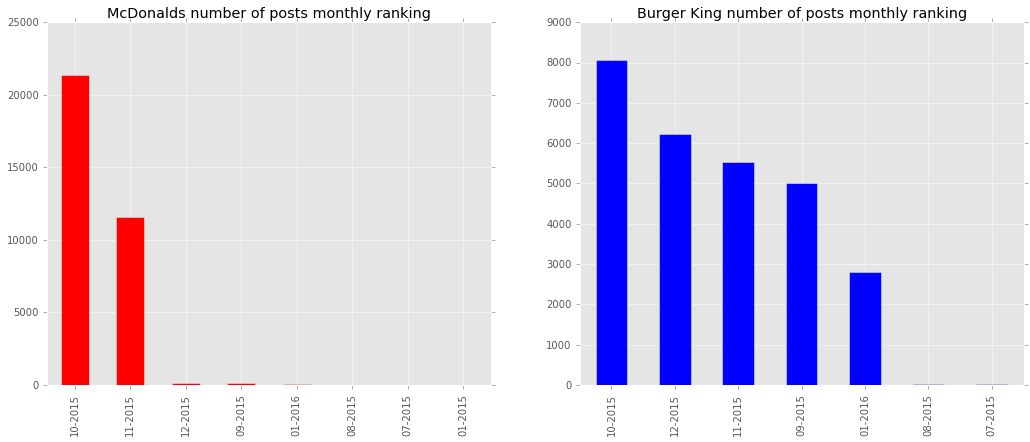

In [21]:
# mc number of tweets per month
fig = plt.figure()
ax1 = fig.add_subplot(121)
df_mc_dates = df_mc_.imageDateCreated_str.dt.strftime("%m-%Y").value_counts()
df_mc_dates[df_mc_dates > 15].plot(kind="bar", colormap="autumn")
ax1.set_title("McDonalds number of posts monthly ranking")

# bk number of tweets per month
ax2 = fig.add_subplot(122)
df_bk_dates = df_bk_.imageDateCreated_str.dt.strftime("%m-%Y").value_counts()
df_bk_dates[df_bk_dates > 15].plot(kind="bar", colormap='bwr')
ax2.set_title("Burger King number of posts monthly ranking")

fig.set_size_inches(17.5, 6.5)
fig.savefig("monthly_ranking_uploads.png")

Distribution during time is not consistent. More or less same total data, should we only use data from october 2015 to february 2016?  
We can see that adding the pictures before and after those 5 months there are only and ~300 pictures of difference...  
Therefore, practically the dataset is only 2 months of data.  

In [17]:
df_mc_.count(axis=0) - df_mc_[(df_mc_['imageDateCreated_str'] > '2015-09-30') & (df_mc_['imageDateCreated_str'] < '2016-12-01')].count()

instaGramId                    298
imageDateCreated               298
imageTagCount                  298
imageFilter                    298
imageLikeCount                 298
imageCommentCount              298
imageLink                      298
imageCaption                   298
imageUsersInImageCollection    298
imageTagCollection             298
imageLongitude                 298
imageLatitude                  298
userFullName                   289
userProfileImage               298
userName                       298
userId                         298
followedByCount                298
followersCount                 298
postedMedia                    298
userBio                        266
userPostedLikedImage           298
comments                       298
googleLabel                    298
googleLabelConfidence          298
googleLogo                     298
googleFaceCount                298
googleText                     214
googleLandMark                  10
product             

#### Fake #nofilter hashtags

In [268]:
count_nofilter_mc = df_mc_[df_mc_['imageTagCollection'].str.contains("nofilter")]["imageFilter"].count()
count_nofilter_bk = df_bk_[df_bk_['imageTagCollection'].str.contains("nofilter")]["imageFilter"].count()
count_fake_nofilter_mc = df_mc_[df_mc_['imageTagCollection'].str.contains("nofilter") & ~ df_mc_['imageFilter'].str.contains("Normal")]["imageFilter"].count()
count_fake_nofilter_bk = df_bk_[df_bk_['imageTagCollection'].str.contains("nofilter") & ~ df_bk_['imageFilter'].str.contains("Normal")]["imageFilter"].count()
print("{}% use the hashtag #nofilter although they actually use a filter".format((100*(count_fake_nofilter_mc+count_fake_nofilter_bk))/
                                                                                 (count_nofilter_mc+count_nofilter_bk)))

12% use the hashtag #nofilter although they actually use a filter


In [269]:
count_nofilter_mc+count_nofilter_bk

471

In [244]:
# some examples
df_mc_[df_mc_['imageTagCollection'].str.contains("nofilter") & ~ df_mc_['imageFilter'].str.contains("Normal")].sort_values("imageLikeCount", ascending=False)

,instaGramId,imageDateCreated,imageTagCount,imageFilter,imageLikeCount,imageCommentCount,imageLink,imageCaption,imageUsersInImageCollection,imageTagCollection,imageLongitude,imageLatitude,userFullName,userProfileImage,userName,userId,followedByCount,followersCount,postedMedia,userBio,userPostedLikedImage,comments,googleLabel,googleLabelConfidence,googleLogo,googleFaceCount,googleText,googleLandMark,product,brand,imageDateCreated_str
3668,1116859551793300961_1912320,1447360055,25,Clarendon,587,3,https://scontent.cdninstagram.com/hphotos-xat1/t51.2885-15/s640x640/sh0.08/e35/12224072_1639002673044371_394918530_n.jpg,Para quem ainda não sabe tem #angrybirds no #mcdonalds #happymeal #gift #toy #kids #fun #red #like #instagood #instadaily #instamood #game #nerd #geek #KarlanoMundo #loveit #ontheroad🚙 #otimizesu...,[4995432],"[""photooftheday"",""red"",""instamood"",""nofilter"",""fun"",""otimizesuasviagens"",""karlanomundo"",""nerd"",""stella"",""gift"",""like"",""toy"",""mcdonalds"",""geek"",""instadaily"",""instagood"",""blues"",""ontheroad🚙"",""kids""...",-39.324234,-7.239378,"""Karla Cristina""",https://scontent.cdninstagram.com/hphotos-xtf1/t51.2885-19/s150x150/12301261_492630847565560_1408786105_a.jpg,"""karlascarpiera""",1912320,20246,1130,3334,Uma pessoa a procura de seu lugar no mundo.\n💕👜✈️💄👑🗽👗👓🎀🚢💍🚕💕\nTwitter @karlascarpiera\nDicas de otimização de suas viagens e outras coisithas.,False,"[""""@colecionadores_toys_mc não vejo a hora de completar a coleção 😍😍"""",""""Fofos demais!! @karlascarpiera"""",""""Lindos💙💞""""]","[""""stuffed toy"""",""""plush"""",""""coin purse"""",""""hand"""",""""toy"""",""""baby toys"""",""""textile""""]","[0.76232409,0.76020789,0.61205155,0.56488037,0.66365063,0.64280719,0.53849965]",[],2,NaN,NaN,0,McDonalds,2015-11-12 20:27:35
15134,1104534683986969761_1912320,1445890816,23,Clarendon,184,1,https://scontent.cdninstagram.com/hphotos-xta1/t51.2885-15/s640x640/sh0.08/e35/12070891_755660244580478_1355581488_n.jpg,#Gordice 🍟🍟#gordices #foodporn #food #instafood #instamood #instagood #KarlanoMundo #mcdonalds #bobs #milkshake #instadaily #fun #love #life #otimizesuavida #otimizesuasviagens #instagram 👻👻 ...,[4995432],"[""otimizesuasviagens"",""karlanomundo"",""instafood"",""instagood"",""instamood"",""nofilter"",""fun"",""milkshake"",""bobs"",""mcdonalds"",""vip"",""otimizesuavida"",""viajecomoumreicomorcamentodeplebeu"",""gordices"",""gor...",-39.325058,-7.223551,"""Karla Cristina""",https://scontent.cdninstagram.com/hphotos-xtf1/t51.2885-19/s150x150/12301261_492630847565560_1408786105_a.jpg,"""karlascarpiera""",1912320,20246,1130,3334,Uma pessoa a procura de seu lugar no mundo.\n💕👜✈️💄👑🗽👗👓🎀🚢💍🚕💕\nTwitter @karlascarpiera\nDicas de otimização de suas viagens e outras coisithas.,False,"[""""Eu quero""""]","[""""dish"""",""""food"""",""""ingredient"""",""""fruit"""",""""flower"""",""""meal"""",""""breakfast""""]","[0.85845464,0.86475962,0.56468445,0.50370061,0.81449717,0.75409526,0.57863671]",[],0,"arts\nLes et\nDB\nへ\nwe\near .""\n",NaN,0,McDonalds,2015-10-26 20:20:16
21297,1098345140331340058_486913703,1445152965,29,Aden,88,18,https://scontent.cdninstagram.com/hphotos-xap1/t51.2885-15/s640x640/sh0.08/e35/12070996_548574958641443_1497068369_n.jpg,분명 #1955파이어 단품으로 시켰는데 집 오면서 보니까 내 손에 콜라도 들려있네... #1955세트 로 잘못받아옴...🍟🍔,[2011443052],"[""goodeats"",""먹짤"",""먹스타그램"",""tbt"",""foodporn"",""nofilter"",""instalike"",""foodoftheday"",""단국대"",""맥도날드"",""allyoucaneat"",""f4f"",""iphone"",""vscocam"",""noms"",""1955파이어"",""foodstagram"",""아이폰"",""천안"",""fff"",""mcdonalds"",""ip...",127.128845,36.825623,"""""",https://scontent.cdninstagram.com/hphotos-xtp1/t51.2885-19/s150x150/12357400_885900234856455_129013773_a.jpg,"""xx_rebecca_x""",486913703,1434,404,551,DKU/Med.,False,"[""""살쪄라"""",""""Your lucky day"""",""""내가봣을땐 1955 세트하신분이요~"""",""""Wonderful :)"""",""""절도 각"""",""""돈도 셋트값으로??ㅋㅋ 아직 안먹어봤는데 괜찮아?"""",""""웅!!!그거 스모키!!바베큐개좋❤️""""]","[""""salami""""]",[0.51833838],[],0,"""이 들이긴\n61LI버태\nHONEY BUTTER CHIP\n지가격!\n교\nlly

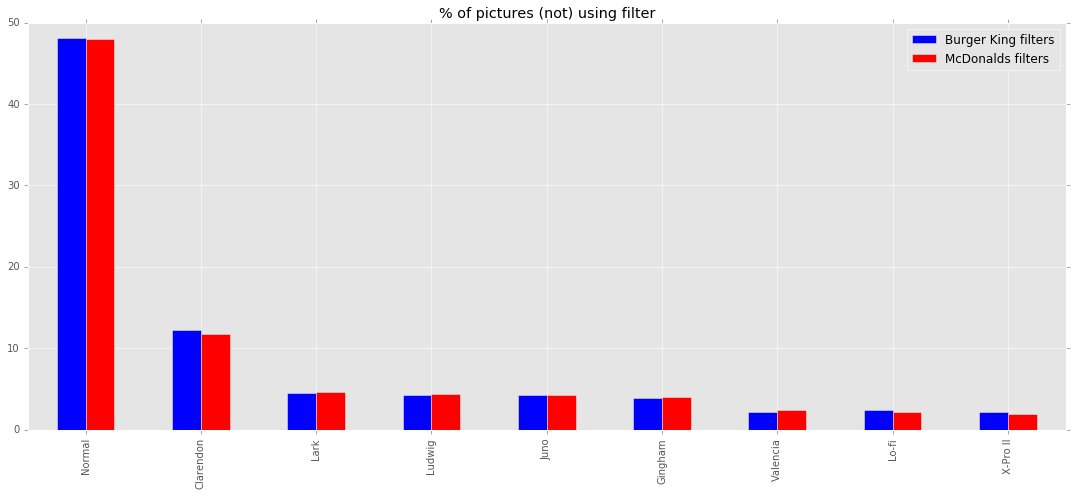

In [171]:
tot_mc_filter = df_mc_['imageFilter'].count()
tot_bk_filter = df_bk_['imageFilter'].count()
total_pic_wfilter = int(tot_bk_filter) + int(tot_mc_filter)
threshold = 2 # 2% of the total for each group, at least

df_filters =  pd.concat([pd.DataFrame(df_bk_['imageFilter'].value_counts()*100/tot_bk_filter).rename(columns={'imageFilter':'Burger King filters'}),
                         pd.DataFrame(df_mc_['imageFilter'].value_counts()*100/tot_mc_filter).rename(columns={'imageFilter':'McDonalds filters'})
                         ], axis=1)
data = df_filters[df_filters['Burger King filters'] > threshold]

# plot
fig, ax = plt.subplots()
plot = data.sort_values('McDonalds filters', ascending=False).plot(ax=ax, kind="bar", colormap="bwr")
ax.set_title("% of pictures (not) using filter")
fig.set_figwidth(15)
fig.set_figheight(7)
fig.tight_layout()
fig.savefig("filters_both.png")


### Geoposition of pictures

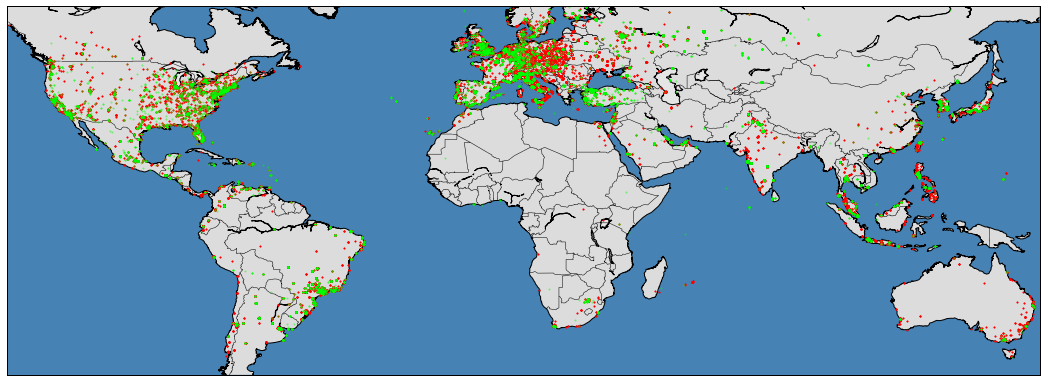

In [122]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure()
fig.set_size_inches(18.5, 14.5)
themap = Basemap(projection='gall',
              llcrnrlon = -135,              # lower-left corner longitude
              llcrnrlat = -48,               # lower-left corner latitude
              urcrnrlon = 155,               # upper-right corner longitude
              urcrnrlat = 63,               # upper-right corner latitude
              resolution = 'l',
              area_thresh = 10000.0,
              )
themap.drawcoastlines()
themap.drawcountries()

themap.fillcontinents(color = 'gainsboro')
themap.drawmapboundary(fill_color='steelblue')
x_mc, y_mc = themap(df_mc_.imageLongitude.values.ravel(),df_mc_.imageLatitude.values.ravel())
x_bk, y_bk = themap(df_bk_.imageLongitude.values.ravel(),df_bk_.imageLatitude.values.ravel())
themap.plot(x_mc, y_mc, 
            '.',                    # marker shape
            color='r',         # marker colour
            markersize=3            # marker size
            )
themap.plot(x_bk, y_bk, 
            '.',                    # marker shape
            color='lime',         # marker colour
            markersize=3,            # marker size
            alpha=0.4
           )
plt.show()
fig.savefig("map_world_both.png", dpi=500)

Green points represent Burger King, red points represent McDonalds

#### Number of followers distribution

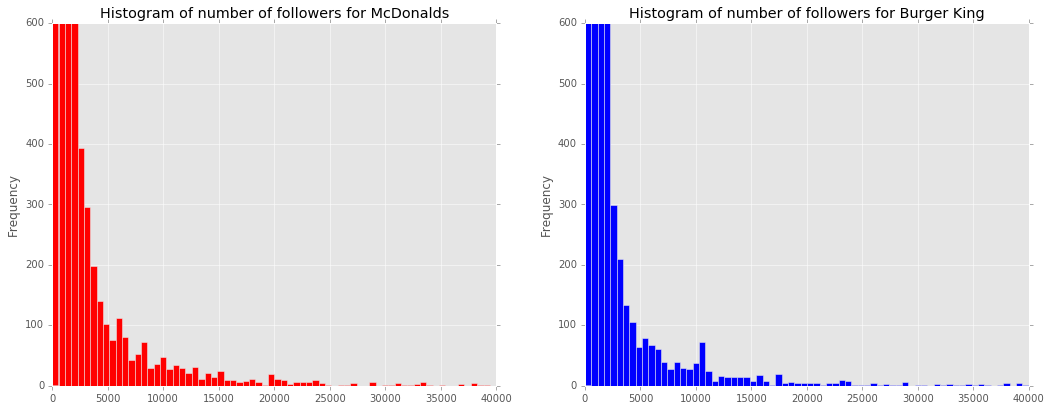

In [21]:
fig = plt.figure()

# mc histogram of number of likes
ax1 = fig.add_subplot(121)
df_mc_['followedByCount'].plot(kind="hist", range=[0,40000], colormap='autumn', align='mid', bins=70)
ax1.set_title("Histogram of number of followers for McDonalds")
ax1.set_ylim([0, 600])
# bk histogram of number of likes
ax2 = fig.add_subplot(122)
df_bk_['followedByCount'].plot(kind="hist", range=[0, 40000], colormap='bwr', align='mid', bins=70)
ax2.set_title("Histogram of number of followers for Burger King")
ax2.set_ylim([0, 600])

fig.set_size_inches(17.5, 6.5)
fig.savefig("image_followers_histogram.png", dpi=250)
# Looks like a Gamma distribution with lambda, sigma = 2
# https://es.wikipedia.org/wiki/Distribuci%C3%B3n_gamma


#### Likes count distribution

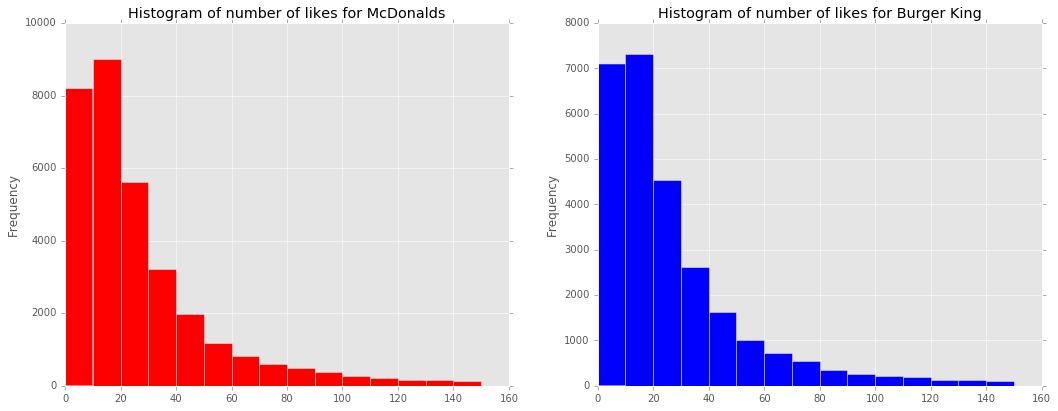

In [10]:
fig = plt.figure()

# mc histogram of number of likes
ax1 = fig.add_subplot(121)
df_mc_['imageLikeCount'].plot(kind="hist", range=[0, 150], colormap='autumn', align='mid', bins=15)
ax1.set_title("Histogram of number of likes for McDonalds")
# bk histogram of number of likes
ax2 = fig.add_subplot(122)
df_bk_['imageLikeCount'].plot(kind="hist", range=[0, 150], colormap='bwr', align='mid', bins=15)
ax2.set_title("Histogram of number of likes for Burger King")

fig.set_size_inches(17.5, 6.5)
fig.savefig("image_likes_histogram.png", dpi=250)
# Looks like a Gamma distribution with lambda, sigma = 2
# https://es.wikipedia.org/wiki/Distribuci%C3%B3n_gamma


In [101]:
df_mc_['likes_followed_ratio'] = (100*df_mc_['imageLikeCount'])/df_mc_['followedByCount']
df_bk_['likes_followed_ratio'] = (100*df_bk_['imageLikeCount'])/df_bk_['followedByCount']

In [102]:
df_mc_['likes_followed_ratio'].loc[0:10]

0      2.272727
1     17.088608
2      3.252033
3      3.161479
4      6.125941
5     71.428571
7      2.302632
8      2.943506
9     51.612903
10    13.235294
Name: likes_followed_ratio, dtype: float64

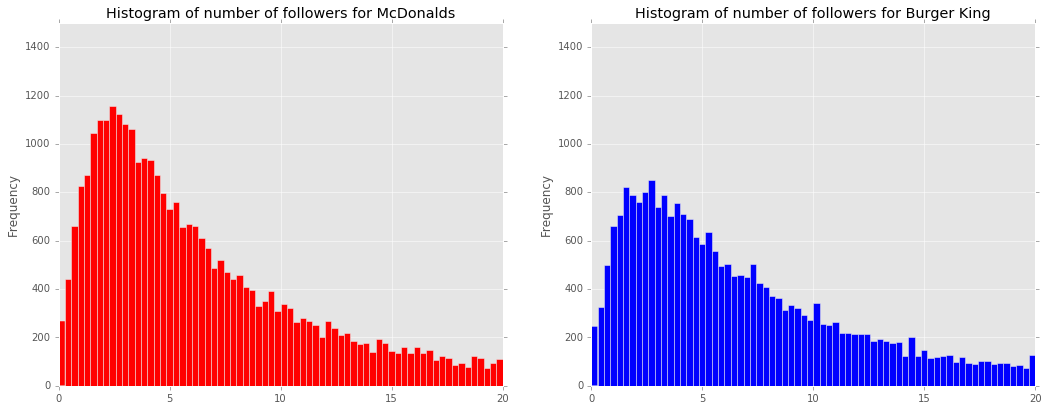

In [35]:
fig = plt.figure()

# mc histogram of number of likes
ax1 = fig.add_subplot(121)
df_mc_['likes_followed_ratio'].plot(kind="hist", range=[0,20], colormap='autumn', align='mid', bins=70)
ax1.set_title("Histogram of number of likes / followers for McDonalds")
ax1.set_ylim([0, 1500])
# bk histogram of number of likes
ax2 = fig.add_subplot(122)
df_bk_['likes_followed_ratio'].plot(kind="hist", range=[0, 20], colormap='bwr', align='mid', bins=70)
ax2.set_title("Histogram of number of likes / followers for Burger King")
ax2.set_ylim([0, 1500])

fig.set_size_inches(17.5, 6.5)
fig.savefig("image_followers_histogram.png", dpi=250)
# Looks like a Gamma distribution with lambda, sigma = 2
# https://es.wikipedia.org/wiki/Distribuci%C3%B3n_gamma


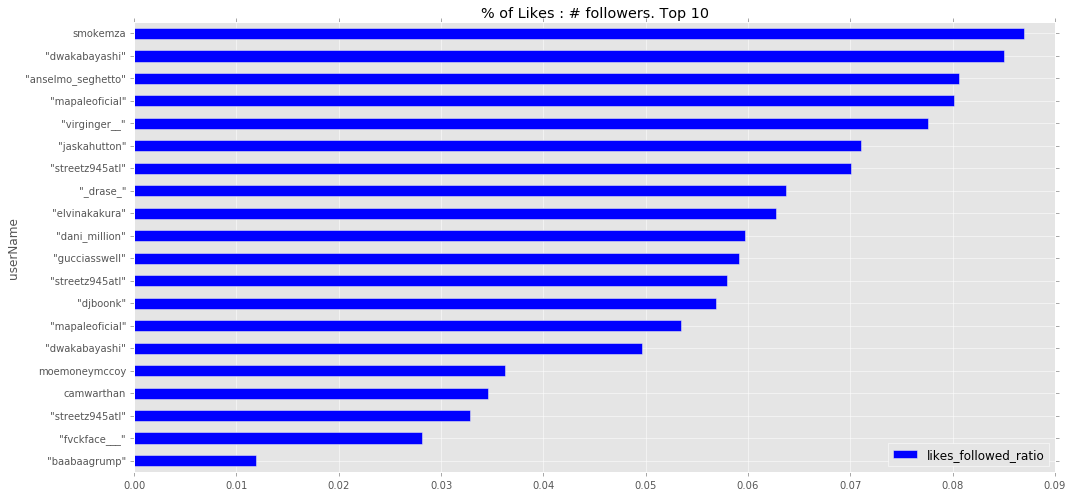

In [105]:
# plot
fig, ax = plt.subplots()
plot = df_mc_[df_mc_['likes_followed_ratio'] > 0].sort_values('likes_followed_ratio').head(20).plot('userName', 'likes_followed_ratio', ax=ax, kind="barh")
ax.set_title("% of Likes : # followers. Top 10")
fig.set_figwidth(15)
fig.set_figheight(7)
fig.tight_layout()
fig.savefig("least_likes_per_follower_rank.png")

In [109]:
likes_followed_ratio_array = np.array(df_mc_[df_mc_['likes_followed_ratio'] > 0].sort_values('likes_followed_ratio')['likes_followed_ratio'].ravel())
a = np.ma.masked_where(likes_followed_ratio_array == np.inf, likes_followed_ratio_array)
print("Count:\t\t%d\nMean:\t\t%.2f\nMax:\t\t%.2f\nMin:\t\t%.2f\nPercentiles:\t%s\n  " % (a.count(),a.mean(), a.max(), a.min(), np.percentile(a, [25, 50, 75])))

Count:		28024
Mean:		9.10
Max:		1200.00
Min:		0.01
Percentiles:	[  2.80745806   5.46448087  10.64568196]
  


#### Histogram of ratio likes/followers in %

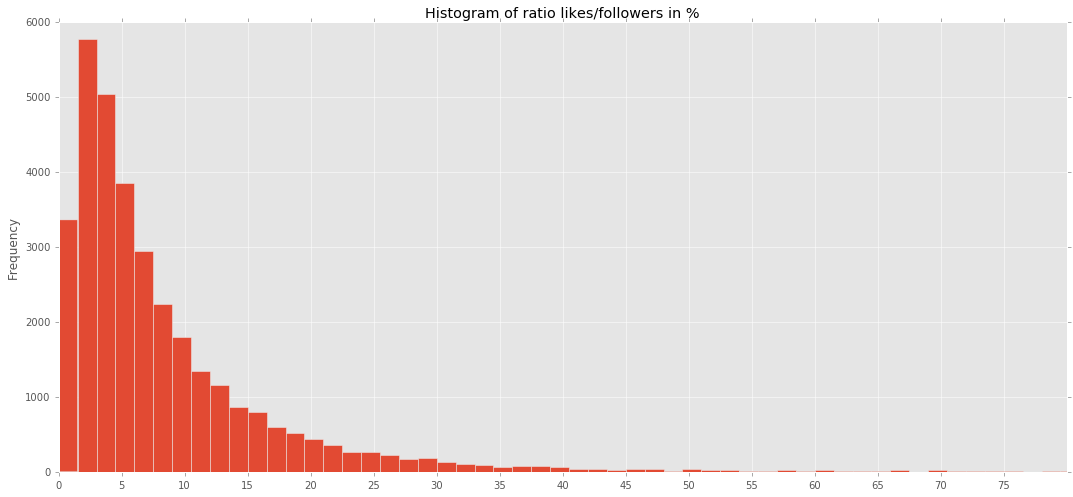

In [415]:
# Only considering those pictures whose owners have followers, otherwise ratio is infinite
fig, ax = plt.subplots()
plot = df_mc_['likes_followed_ratio'].replace([np.inf, -np.inf], np.nan).dropna().plot(ax=ax, kind="hist", bins=800)
ax.set_title("Histogram of ratio likes/followers in %")
fig.set_figwidth(15)
ax.set_xlim([0,80])
ax.set_xticks(range(0,80,5))
fig.set_figheight(7)
fig.tight_layout()
fig.savefig("likes_per_follower_hist.png")

#### Number of followers distribution

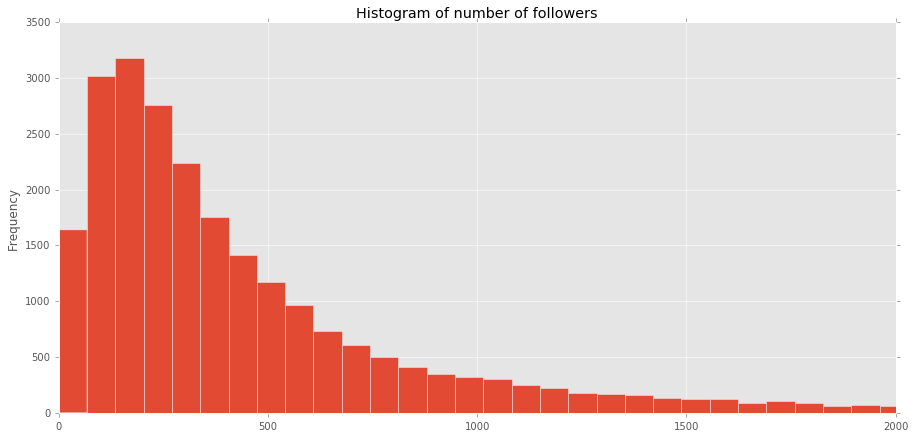

In [433]:
# Only considering those pictures whose owners have followers, otherwise ratio is infinite
fig, ax = plt.subplots()
plot = df_mc_.drop_duplicates(subset=['userName']).replace([np.inf, -np.inf], np.nan)['followedByCount'].dropna().plot(ax=ax, kind="hist", bins=8000)
ax.set_title("Histogram of number of followers")
fig.set_figwidth(15)
ax.set_xlim([0,2000])
ax.set_ylim([0,3500])
#ax.set_xticks(range(0,80,5))
fig.set_figheight(7)
#fig.tight_layout()
fig.savefig("number_followers_hist.png")

In [214]:
df_mc_.head(1)

,instaGramId,imageDateCreated,imageTagCount,imageFilter,imageLikeCount,imageCommentCount,imageLink,imageCaption,imageUsersInImageCollection,imageTagCollection,imageLongitude,imageLatitude,userFullName,userProfileImage,userName,userId,followedByCount,followersCount,postedMedia,userBio,userPostedLikedImage,comments,googleLogo,googleFaceCount,googleText,googleLandMark,product,brand,googleLabel_list,googleLabelConfidence_list,googleLabel_dict,imageTagCollection_list,imageDateCreated_str,weekend_attribute,famous_attribute,activity_attribute,imageCaption_clean,likes_followed_ratio,sentiment_attribute,filter_attribute,face_attribute,logo_attribute,food_attribute,sentiment_attribute_num,conjoint_category
0,1165524631240624607_638926073,1453161384,7,Normal,3,0,https://scontent.cdninstagram.com/hphotos-xpt1/t51.2885-15/s320x320/e35/12545400_131527523893372_2086774170_n.jpg,I will gladly pay you Tuesday for a hamburger today. #popeye #popeyethesailorman #wimpy #wimpysburgers #jackinthebox #mcdonalds #burgerking,[],"[""burgerking"",""popeyethesailorman"",""mcdonalds"",""wimpysburgers"",""jackinthebox"",""popeye"",""wimpy""]",-89.8231,37.9139,"""Lisa Qualls Rebman""",https://scontent.cdninstagram.com/hphotos-xaf1/t51.2885-19/s150x150/12276988_191716141166756_530478826_a.jpg,"""lisarebs""",638926073,132,268,1111,"Stay at home mom to 3 kids. Active in pregnancy & infant loss support. Dealing with a spinal disease, trying to live a happy life with minimal pain.",False,[],[],0,"""IT'S TUESDAY BITCH!!!\nWHERE'S OUR-\nFUCKING MONEY!!!""",NaN,0,McDonalds,"[cartoon, comics, artwork]","[0.92367387, 0.67196417, 0.70198238]","{u'comics': 0.67196417, u'cartoon': 0.92367387, u'artwork': 0.70198238}","[burgerking, popeyethesailorman, mcdonalds, wimpysburgers, jackinthebox, popeye, wimpy]",2016-01-18 23:56:24,weekend no,common,low,"[i, gladly, pay, tuesday, hamburger, today, ]",2.272727,positive,filter no,face no,logo no,food no,0.5,0


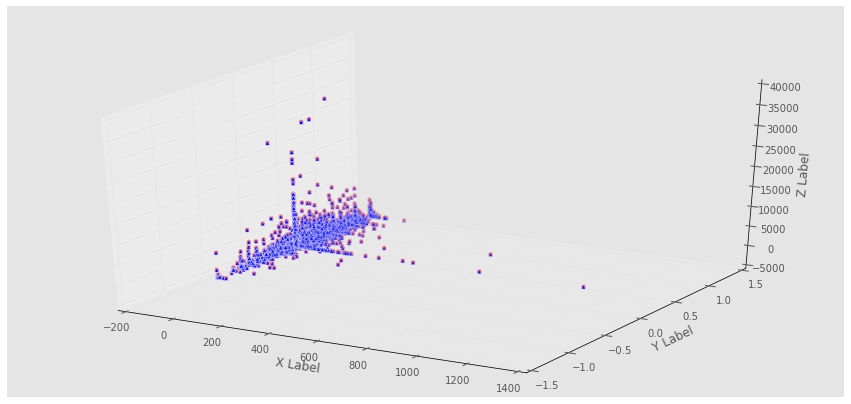

In [216]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


def randrange(n, vmin, vmax):
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 100
c, m, zl, zh = ('r', 'o', -50, -25)
xs = df_mc_["likes_followed_ratio"]
ys = df_mc_["sentiment_attribute_num"]
zs = df_mc_["postedMedia"]
ax.scatter(xs, ys, zs, c=c, marker=m)
                 
c, m, zl, zh = ('b', '^', -30, -5)
xs = df_bk_["likes_followed_ratio"]
ys = df_bk_["sentiment_attribute_num"]
zs = df_bk_["postedMedia"]
ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
fig.set_figwidth(15)
fig.set_figheight(7)
plt.show()



